In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import BertForMaskedLM, BertTokenizer
import pandas as pd
import json

WORKING_DIR = '/content/drive/MyDrive/AlgoExplanations/Bert'

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForMaskedLM.from_pretrained("bert-base-cased")

with open(f"{WORKING_DIR}/all_blogs_comments.json", 'r') as fp:
  blog_dataset = json.load(fp)


all_comments = [c['text'] for b in blog_dataset for c in b['comments']]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
import bs4

preprocessed_comments = []

for comment in all_comments:
  p_comment = bs4.BeautifulSoup(comment).text
  p_comment = p_comment.replace('$$$', '$')
  preprocessed_comments.append(p_comment)

In [4]:
from collections import defaultdict
all_tokens = [tokenizer(text) for text in preprocessed_comments]
all_tokens = [input_id for t in all_tokens for input_id in t['input_ids']]
frequency_token_table = defaultdict(int)

for input_id in all_tokens:
  frequency_token_table[int(input_id)]+=1
frequency_sorted_list = list(frequency_token_table.items())
frequency_sorted_list = sorted(frequency_sorted_list, key = lambda x:x[1], reverse = True)

Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors


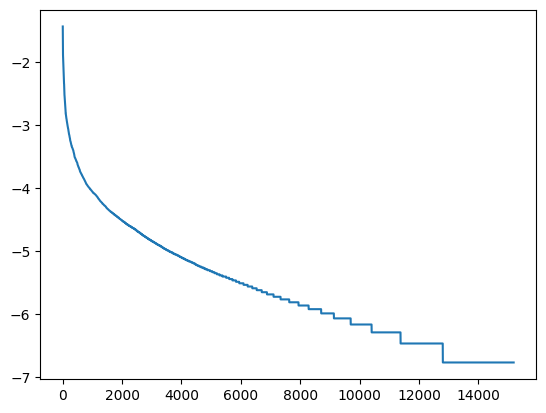

In [5]:
nr_all_tokens = 0

for k,v in frequency_sorted_list:
  nr_all_tokens+= v

frequency_normalized_token_table = {k:v / nr_all_tokens  for k,v in frequency_token_table.items()}

frequency_normalized_sorted_list = list(frequency_normalized_token_table.items())
frequency_normalized_sorted_list = sorted(frequency_normalized_sorted_list, key = lambda x:x[1], reverse = True)

import matplotlib.pyplot as plt
import numpy as np
import math
plt.plot([np.log10(v) for k,v in frequency_normalized_sorted_list])
plt.show()

In [6]:
import numpy as np
def subsample_discard(tok_idx, t = 0.0001):
  return np.maximum(0.0, 1.0 - np.sqrt(t / frequency_normalized_token_table[tok_idx]))

In [7]:
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import torch
import numpy as np
from tqdm import tqdm
import random
from collections import defaultdict

DEVICE = "cuda"
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
random.shuffle(preprocessed_comments)

seq_len = 510

class MlmDataset(Dataset):
  def __init__(self, textList):
    tokenized_dict = [tokenizer(text, add_special_tokens = False) for text in textList]

    tokenized_input_ids = [tokens["input_ids"] for tokens in tokenized_dict]
    tokenized_token_type_ids = [tokens["token_type_ids"] for tokens in tokenized_dict]
    tokenized_attention_mask = [tokens["attention_mask"] for tokens in tokenized_dict]

    self.dataset = []
    

    for input_ids, token_type_ids, attention_mask in zip(tokenized_input_ids, tokenized_token_type_ids, tokenized_attention_mask):
      nr = len(input_ids)// seq_len

      for idx in range(nr):
        self.dataset.append({"input_ids": [tokenizer.cls_token_id] + input_ids[idx * seq_len : (idx+1)*seq_len] + [tokenizer.sep_token_id], 
                            "token_type_ids": [0] + token_type_ids[idx * seq_len : (idx+1)*seq_len] + [0], 
                            "attention_mask": [1] + attention_mask[idx * seq_len : (idx+1)*seq_len] + [1]})
        
      if(len(input_ids) % seq_len > 0):
        r = len(input_ids) % seq_len
        trunc_input_ids = [tokenizer.cls_token_id] + input_ids[-r : ] + [tokenizer.sep_token_id]
        trunc_token_type_ids = [0] + token_type_ids[-r : ] + [0]
        trunc_attention_mask = [1] + attention_mask[-r : ] + [1]

        self.dataset.append({"input_ids": trunc_input_ids, 
                          "token_type_ids": trunc_token_type_ids, 
                          "attention_mask": trunc_attention_mask})


  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    return {k:np.array(v) for k,v in self.dataset[idx].items()}, np.array(self.dataset[idx]["input_ids"])


In [8]:
import torch.cuda.amp
import math
_vocabulary_subsample = np.zeros(len(tokenizer.vocab), dtype = np.float32)

for idx, v in frequency_normalized_token_table.items():
    _vocabulary_subsample[idx] = v



def mlm_collator(batch):
  collated_input_ids = []
  collated_token_type_ids= []
  collated_attention_mask = []
  collated_y = []

  max_pad_size = 0

  for x, y in batch:
    input_ids = x["input_ids"]

    input_subsample_prob = _vocabulary_subsample[input_ids]
    random_prob = np.random.rand(input_subsample_prob.shape[0])

    exclude = random_prob < input_subsample_prob


    mask = np.random.binomial(1, 0.15, input_ids.shape)
    mask[exclude] = 0

    type_masking_strategy = np.random.rand(mask.shape[0])

    input_ids[(type_masking_strategy > 0.2) & (mask == 1)] = tokenizer.mask_token_id

    nr_random_indices = np.sum((type_masking_strategy < 0.1) & (mask == 1))
    if(nr_random_indices > 0):
      input_ids[(type_masking_strategy < 0.1) & (mask == 1)] =  np.random.randint(107, len(tokenizer.vocab), nr_random_indices)  
    
    y[mask == 0] = -100

    max_pad_size = max(max_pad_size, input_ids.shape[0])
    collated_input_ids.append(torch.from_numpy(input_ids))
    collated_token_type_ids.append(torch.from_numpy(x["token_type_ids"]))
    collated_attention_mask.append(torch.from_numpy(x["attention_mask"]))

    collated_y.append(torch.from_numpy(y))
  
  for idx in range(len(collated_input_ids)):
    r = max_pad_size - collated_input_ids[idx].shape[0]

    if(r > 0):
      collated_input_ids[idx] = torch.cat([collated_input_ids[idx], torch.tensor([tokenizer.pad_token_id] * r)])
      collated_token_type_ids[idx] = torch.cat([collated_token_type_ids[idx], torch.tensor([0] * r)])
      collated_attention_mask[idx] = torch.cat([collated_attention_mask[idx], torch.tensor([0] * r)])
      collated_y[idx] = torch.cat([collated_y[idx], torch.tensor([-100] * r)])


  
  return {"input_ids": torch.stack(collated_input_ids).to(DEVICE), "token_type_ids":torch.stack(collated_token_type_ids).to(DEVICE), "attention_mask": torch.stack(collated_attention_mask).to(DEVICE)}, torch.stack(collated_y).to(DEVICE)


model.to(DEVICE)


train_comments = preprocessed_comments[:-8900*2]
val_comments = preprocessed_comments[-8900*2:-8900]
test_comments = preprocessed_comments[-8900:]

train_mlmDataset = MlmDataset(train_comments)
train_dataloader = DataLoader(train_mlmDataset, batch_size = 16, shuffle=True, collate_fn = mlm_collator)

val_mlmDataset = MlmDataset(val_comments)
val_dataloader = DataLoader(val_mlmDataset, batch_size = 16, shuffle=False, collate_fn = mlm_collator)

test_mlmDataset = MlmDataset(test_comments)
test_dataloader = DataLoader(test_mlmDataset, batch_size = 16, shuffle=False, collate_fn = mlm_collator)

epochs = 10

optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()


for epoch in range(epochs):
  pbar = tqdm(train_dataloader)
  model.train()
  average_train_loss = 0
  average_val_loss = 0
  for x, y in pbar:
    optimizer.zero_grad()
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        outputs = model(**x)
        loss = criterion(outputs["logits"].permute(0,2,1), y)

    scaler.scale(loss).backward()
    scaler.step(optimizer)


    loss = loss.detach().cpu()
    
    average_train_loss+= loss
    pbar.set_postfix({"loss": loss})
    scaler.update()

  pbar = tqdm(val_dataloader)
  model.eval()
  for x, y in pbar:
    with torch.no_grad():
      with torch.autocast(device_type='cuda', dtype=torch.float16):
        outputs = model(**x)
        loss = criterion(outputs["logits"].permute(0,2,1), y)

      loss = loss.detach().cpu()
      
      average_val_loss+= loss
      pbar.set_postfix({"loss": loss})

  print(f"Average train loss {average_train_loss / len(train_dataloader)}")
  print(f"Average val loss {average_val_loss / len(val_dataloader)}")
  model.save_pretrained(f"{WORKING_DIR}/FinetunedModels/finetuned-bert_{average_val_loss / len(val_dataloader)}_{epoch}")
  scheduler.step()

average_test_loss = 0
pbar = tqdm(test_dataloader)
model.eval()
for x, y in pbar:
  with torch.no_grad():
    outputs = model(**x)
    loss = criterion(outputs["logits"].permute(0,2,1), y)

    loss = loss.detach().cpu()
    
    average_test_loss+= loss
    pbar.set_postfix({"loss": loss})

print(f"Average test loss {average_test_loss / len(test_dataloader)}")


100%|██████████| 564/564 [01:41<00:00,  5.54it/s, loss=tensor(1.5035)]


Average train loss 2.116107225418091
Average val loss 1.8622866868972778


100%|██████████| 564/564 [01:42<00:00,  5.50it/s, loss=tensor(2.6807)]


Average train loss 1.857279658317566
Average val loss 1.762777328491211


100%|██████████| 564/564 [01:42<00:00,  5.53it/s, loss=tensor(2.4571)]


Average train loss 1.735945224761963
Average val loss 1.6471445560455322


100%|██████████| 564/564 [01:41<00:00,  5.54it/s, loss=tensor(2.3905)]


Average train loss 1.6426935195922852
Average val loss 1.6191376447677612


100%|██████████| 564/564 [01:41<00:00,  5.54it/s, loss=tensor(1.6974)]


Average train loss 1.5627449750900269
Average val loss 1.5537625551223755


100%|██████████| 564/564 [01:41<00:00,  5.54it/s, loss=tensor(1.3112)]


Average train loss 1.506632924079895
Average val loss 1.5303939580917358


100%|██████████| 564/564 [01:42<00:00,  5.53it/s, loss=tensor(1.6668)]


Average train loss 1.4622950553894043
Average val loss 1.4857826232910156


100%|██████████| 564/564 [01:42<00:00,  5.49it/s, loss=tensor(1.1315)]


Average train loss 1.4224289655685425
Average val loss 1.4777177572250366


100%|██████████| 564/564 [01:42<00:00,  5.51it/s, loss=tensor(1.3008)]


Average train loss 1.3957219123840332
Average val loss 1.4512251615524292


100%|██████████| 564/564 [01:42<00:00,  5.50it/s, loss=tensor(1.5499)]


Average train loss 1.369403600692749
Average val loss 1.4460794925689697


100%|██████████| 564/564 [03:47<00:00,  2.48it/s, loss=tensor(1.3669)]

Average test loss 1.4476031064987183


In [9]:
checkpoint = {
    "epoch":10,
    "optimizer": optimizer.state_dict(),
    "lr_sched": scheduler
}

torch.save(checkpoint, f'{WORKING_DIR}/optimizer_checkpoint.pth')

In [10]:
# dataset = MlmDataset(preprocessed_comments)

In [11]:
# test_idx = 70
# o = tokenizer.decode(dataset[test_idx][0]["input_ids"])
# dataloader = DataLoader(dataset, batch_size = 1, shuffle=False, collate_fn = mlm_collator)
# s = ''
# z = ''
# idx =0 
# for item,r in dataloader:
#   s = tokenizer.decode(item["input_ids"][0])
#   z = tokenizer.decode(r[0])
#   if(idx == test_idx):
#     break
#   idx+=1
# display(o)
# display(s)
# display(z)

In [22]:
import torch
text = "How can problem [MASK] be solved?"

def predict(tokenizer, model, text):
    tokens = tokenizer(text, return_tensors="pt") 
    tokens = {k:v.to(DEVICE) for k,v in tokens.items()}

    logits = model(**tokens)["logits"]

    logits = logits.detach().cpu()

    probabilities = torch.nn.functional.softmax(logits, -1)


    token_ids = tokens["input_ids"].detach().cpu()

    token_ids = token_ids[0]
    probabilities = probabilities[0]

    for i in range(len(token_ids)):
        if(token_ids[i] == tokenizer.mask_token_id):
            scores = [(k,v) for k,v in enumerate(probabilities[i])]
            scores = sorted(scores, key= lambda x:x[1], reverse = True)
            token_ids[i] = scores[0][0]
    return tokenizer.decode(token_ids)

print("".join(['#']*20))
print(predict(tokenizer, model, text))


####################
[CLS] How can problem C be solved? [SEP]
